# This notebook compares eukaryotic taxa seen in shotgun metagenomes with those in metabarcoding sequence data. It is designed to use the output of sourmash for shotgun metagenomes and DADA2, BLAST, and MEGAN LCA for metabarcoding data. Sourmash databases should be GTDB and MMETSP and BLAST database should be NCBI-nr.

## This is currently written to assess taxa at the genus level, but can easily be modified for other levels of taxonomic resolution. Additionally, GTDB and MMETSP only contain microbial taxa (prokaryotic and eukaryotic, respectively). For higher organisms, different databases will be needed. I will address those questions in a separate script.

In [1]:
import pandas as pd
import os as os
import glob as glob
import numpy as np
import functools as ft
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

## 01. Compile lists of species and genera observed in shotgun metagenomes

### Function to combine and reformat genus- and species-level data

In [2]:
def compile_taxa_lists(file, sample):
    tax = pd.read_csv(file)
    names = ['query name','rank','fraction','lineage','query_md5','query_filename',
         'f_weighted_at_rank','bp_match_at_rank']
    tax.columns = names
    lineage = tax[['lineage']].copy()
    lineage[['Domain','Phylum','Class','Order','Family','Genus',
             'Species']] = lineage['lineage'].str.split(';', n=7, expand=True)
    euks = lineage.loc[lineage['Domain'] == 'Eukaryota']
    euk_genus = pd.DataFrame(euks['Genus'].unique())
    euk_genus.columns = ['Genus']
    euk_genus = euk_genus.dropna()
    euk_genus['Metagenome_sample'] = sample
    euk_species = pd.DataFrame(euks['Species'].unique())
    euk_species.columns = ['Species']
    euk_species = euk_species.dropna()
    euk_species['Metagenome_sample'] = sample
    return(euk_genus, euk_species)

### Apply function to all samples in a directory

In [9]:
# Change this directory for each data set
os.chdir("/Users/nastassia.patin/Desktop/Projects/Lasker2019/Metagenomes/sourmash/summaries")

In [10]:
df_gen_mgns = []
df_spp_mgns = []

for file in glob.glob('*summarized.csv'):
    a, b = file.split('_int') # '_S' for Lasker 2018, '_R1' for Flyer 2018, '_int' for Lasker 2019; change as needed for other data sets
    gen, sp = compile_taxa_lists(file, a)
    df_gen_mgns.append(gen)
    df_spp_mgns.append(sp)
    
df_gen_mgns = pd.concat(df_gen_mgns)
df_spp_mgns = pd.concat(df_spp_mgns)

### Assign identifier to dataframe and repeat the process for other data set(s)

In [8]:
df_gen_mgns_Lasker2018 = df_gen_mgns

In [5]:
df_gen_mgns_Flyer2018 = df_gen_mgns

In [11]:
df_gen_mgns_Lasker2019 = df_gen_mgns

### Combine all dataframes

In [12]:
df_gen_mgns = pd.concat([df_gen_mgns_Lasker2018, df_gen_mgns_Flyer2018, df_gen_mgns_Lasker2019], axis=0)
df_gen_mgns

,Genus,Metagenome_sample
1,Bathycoccus,D0079A
2,Micromonas,D0079A
3,Aureococcus,D0079A
4,Pelagomonas,D0079A
5,Emiliania,D0079A
...,...,...
8,Isochrysis,1903c127_7m-1
9,Polarella,1903c127_7m-1
10,Thalassiosira,1903c127_7m-1
11,Phaeocystis,1903c127_7m-1


## 02. Compile lists of species and genera observed in metabarcoding data

### Can use either 18S or COI data

In [26]:
os.chdir("/Users/nastassia.patin/Desktop/Projects/eCruises 2018/Flyer2018/Metagenomes/sourmash/COI comparison")

### Import and filter ASV table

In [28]:
file = 'Flyer2018_COI_asv_tax_table_noCs_mgnmatches.csv'
asvs = pd.read_csv(file)
asvs = asvs[(asvs['Kingdom'] != 'no_hit') & 
            (asvs['Kingdom'] != 'unassigned')] # Remove ASVs wit 'no_hit' or 'unassigned' in Kingdom
asvs

,lineage,Kingdom,Phylum,Class,Order,Family,Genus,Species,CN18FESPkoa_SC24,CN18FESPkoa_SC26,...,CN18Sc09_2_eDNA,CN18Sc10_2_eDNA,CN18Sc14_2_eDNA,CN18Sc14_8_eDNA,CN18Sc15_2_eDNA,CN18Sc15_8_eDNA,CN18Sc18_2_eDNA,CN18Sc18_8_eDNA,CN18Sc27_2_eDNA,CN18Sc27_8_eDNA
0,Eukaryota;Arthropoda;Malacostraca;Decapoda;Opl...,Eukaryota,Arthropoda,Malacostraca,Decapoda,Oplophoridae,Acanthephyra,Acanthephyra curtirostris,0,0,...,0,0,1,0,0,22,0,0,0,0
1,Eukaryota;Haptophyta;Haptophyta;Isochrysidales...,Eukaryota,Haptophyta,Haptophyta,Isochrysidales,Noelaerhabdaceae,Emiliania,Emiliania huxleyi,0,0,...,198,550,122,499,26,552,8,267,14,1098
2,Eukaryota;Oomycota;Oomycetes;Saprolegniales;Sa...,Eukaryota,Oomycota,Oomycetes,Saprolegniales,Saprolegniaceae,g_,s_,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Eukaryota;Arthropoda;Malacostraca;Decapoda;una...,Eukaryota,Arthropoda,Malacostraca,Decapoda,unassigned,unassigned,s_,0,0,...,0,0,2,0,0,1,0,0,0,0
4,Eukaryota;Chordata;Ascidiacea;Enterogona;Ascid...,Eukaryota,Chordata,Ascidiacea,Enterogona,Ascidiidae,Ascidia,Ascidia ahodori,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15057,Eukaryota;unassigned;unassigned;unassigned;una...,Eukaryota,unassigned,unassigned,unassigned,unassigned,g_,s_,0,0,...,0,0,0,0,0,0,0,0,0,0
15058,Eukaryota;Arthropoda;Hexanauplia;Poecilostomat...,Eukaryota,Arthropoda,Hexanauplia,Poecilostomatoida,Oncaeidae,g_,s_,0,0,...,0,0,0,0,0,0,0,0,0,0
15059,Eukaryota;Oomycota;Oomycetes;unassigned;unassi...,Eukaryota,Oomycota,Oomycetes,unassigned,unassigned,g_,s_,0,0,...,0,0,0,0,0,0,0,0,0,0
15061,Eukaryota;Arthropoda;Hexanauplia;Calanoida;Cla...,Eukaryota,Arthropoda,Hexanauplia,Calanoida,Clausocalanidae,Clausocalanus,Clausocalanus parapergens,0,0,...,0,0,0,0,0,0,0,0,0,0


### Function to reformat taxa lists

In [30]:
def reformat_ASV_table(df, taxon_to_drop):
    samples = [col for col in df.columns if 'CN18' in col] # Use identifier in all sample names; 'CN18' for Flyer 2018, 'Lasker' for Lasker 2018, 'CN19' for Lasker 2019
    cols_to_drop = ['lineage','Kingdom','Phylum','Class','Order','Family',taxon_to_drop]
    df = df.drop(cols_to_drop, axis=1)
    taxon = [x for x in df.columns if 'CN18' not in x] # Use identifier in all sample names
    df_melt = pd.melt(df, id_vars=taxon, value_vars=samples)
    df_melt = df_melt.rename(columns = {'variable':'ASV_sample', 
                                                    'value':'Read count'})
    mask = ['g_', 's_', 'unknown', 'unassigned'] # identify ASVs where taxon is unknown or unassigned
    taxon = ''.join(taxon) # Convert list to string
    df_asvs = df_melt.loc[~df_melt[taxon].isin(mask), :]
    df_asvs = df_asvs[df_asvs['Read count'] != 0]
    df_asvs = df_asvs.drop(['Read count'], axis=1)
    df_asvs = df_asvs.drop_duplicates()
    return(df_asvs)

#### For genus-level list

In [31]:
df_gen_asvs = reformat_ASV_table(asvs, 'Species')
df_gen_asvs

,Genus,ASV_sample
6,Homo,CN18FESPkoa_SC24
7,Emiliania,CN18FESPkoa_SC24
32,Euphausia,CN18FESPkoa_SC24
33,Bathycoccus,CN18FESPkoa_SC24
61,Paracalanus,CN18FESPkoa_SC24
...,...,...
562051,Rhizosolenia,CN18Sc27_8_eDNA
562118,Skeletonema,CN18Sc27_8_eDNA
562973,Pseudo-nitzschia,CN18Sc27_8_eDNA
564100,Scrippsia,CN18Sc27_8_eDNA


#### For species-level list

In [32]:
df_spp_asvs = reformat_ASV_table(asvs, 'Genus')
df_spp_asvs

,Species,ASV_sample
6,Homo sapiens,CN18FESPkoa_SC24
7,Emiliania huxleyi,CN18FESPkoa_SC24
32,Euphausia pacifica,CN18FESPkoa_SC24
33,Bathycoccus prasinos,CN18FESPkoa_SC24
61,Paracalanus sp. C AC-2013,CN18FESPkoa_SC24
...,...,...
561750,Stephanopyxis turris,CN18Sc27_8_eDNA
562051,Rhizosolenia setigera,CN18Sc27_8_eDNA
562118,Skeletonema japonicum,CN18Sc27_8_eDNA
564100,Scrippsia pacifica,CN18Sc27_8_eDNA


### Assign identifier to dataframe and repeat the process for other data set(s)

In [25]:
df_gen_asvs_Lasker2018 = df_gen_asvs

In [33]:
df_gen_asvs_Flyer2018 = df_gen_asvs

In [18]:
df_gen_asvs_Lasker2019 = df_gen_asvs

### Combine all dataframes

In [34]:
df_gen_asvs = pd.concat([df_gen_asvs_Lasker2018, df_gen_asvs_Flyer2018, df_gen_asvs_Lasker2019], axis=0)
df_gen_asvs

,Genus,ASV_sample
0,Emiliania,Lasker18Sc122_3_D0052_VV
6,Acanthephyra,Lasker18Sc122_3_D0052_VV
7,Phaeocystis,Lasker18Sc122_3_D0052_VV
16,Sphaeronectes,Lasker18Sc122_3_D0052_VV
42,Aureococcus,Lasker18Sc122_3_D0052_VV
...,...,...
1383915,Margalefidinium,CN19_Nisk_Far_60m_3
1383952,Chaetoceros,CN19_Nisk_Far_60m_3
1384664,Nannochloropsis,CN19_Nisk_Far_60m_3
1385550,Thysanoessa,CN19_Nisk_Far_60m_3


## 03. Extract taxa common to both data sets and taxa unique to one data set

### To get genera present in both sheets

In [35]:
genera_same = pd.merge(df_gen_mgns, df_gen_asvs, how = 'inner', on = ['Genus'])
genera_same['Genus'].unique()

array(['Bathycoccus', 'Micromonas', 'Aureococcus', 'Pelagomonas',
       'Emiliania', 'Florenciella', 'Polarella', 'Phaeocystis',
       'Alexandrium', 'Thalassiosira', 'Minutocellus', 'Chaetoceros',
       'Pseudo-nitzschia', 'Skeletonema', 'Asterionellopsis',
       'Coscinodiscus', 'Dinophysis', 'Nephroselmis', 'Ditylum',
       'Dictyocha', 'Rhizosolenia'], dtype=object)

In [36]:
os.chdir("/Users/nastassia.patin/Desktop/Projects/eCruises_TIMESERIES/Euks-mgns-asvs/2018 2019 COI comparison")

In [37]:
genera_same_unique = pd.DataFrame(genera_same['Genus'].unique(), columns = ['Genus'])
genera_same_unique.to_csv('COI_genera_ASVs_mgns_BOTH.csv', index=None)

### To get genera only in one sheet or another

In [38]:
common = df_gen_mgns.merge(df_gen_asvs, on=['Genus'])

#### Present only in metagenomes

In [39]:
df_gen_mgns_only = df_gen_mgns[(~df_gen_mgns.Genus.isin(common.Genus))]
df_gen_mgns_only['Genus'].unique()

array(['Bolidomonas', 'Chrysochromulina', 'Ochromonas', 'Isochrysis',
       'Azadinium', 'Heterosigma', 'Ostreococcus', 'Pycnococcus',
       'Gephyrocapsa', 'Acanthoeca-like', 'Rhizochromulina', 'Geminigera',
       'Nitzschia', 'Polytomella', 'Picochlorum', 'Prasinoderma',
       'Imantonia', 'Partenskyella', 'Pelagococcus', 'Phaeomonas',
       'Pelagodinium', 'Fragilariopsis', 'Unidentifiedeukaryote',
       'Crypthecodinium', 'Pseudopedinella', 'Mesodinium', 'Hemiselmis',
       'Heterocapsa', 'Corethron', 'Tiarina', 'Pteridomonas', 'Vannella',
       'Favella', 'Coccolithus', 'Strombidinopsis', 'Glenodinium'],
      dtype=object)

In [40]:
df_gen_mgns_only_unique = pd.DataFrame(df_gen_mgns_only['Genus'].unique(), columns = ['Genus'])
df_gen_mgns_only_unique.to_csv('COI_genera_mgns_ONLY.csv', index=None)

#### Present only in amplicons

In [41]:
df_gen_asvs_only = df_gen_asvs[(~df_gen_asvs.Genus.isin(common.Genus))]
df_gen_asvs_only['Genus'].unique()

array(['Acanthephyra', 'Sphaeronectes', 'Clausocalanus', 'Thysanoessa',
       'Praya', 'Chuniphyes', 'Euphausia', 'Nanomia', 'Urodasys',
       'Ctenocalanus', 'Lucicutia', 'Nematoscelis', 'Gonatus',
       'Thalassionema', 'Rhynchosporium', 'Chloroparvula',
       'Pseudoparamoeba', 'Lebbeus', 'Cafeteria', 'Pseudosagitta',
       'Pleuromamma', 'Acartia', 'Scrippsia', 'Margalefidinium',
       'Paramoeba', 'Paracalanus', 'Leuckartiara', 'Penicillium',
       'Eucalanus', 'Sergestes', 'Gymnodinium', 'Solmissus', 'Triconia',
       'Calanus', 'Amphipholis', 'Ophiura', 'Dendraster',
       'Parengyodontium', 'Doryteuthis', 'Coryne', 'Calocalanus',
       'Ascidia', 'Fibrocapsa', 'Oithona', 'Salpa', 'Chloropicon',
       'Haliphron', 'Metridia', 'Pseudocalanus', 'Lissodelphis',
       'Colobonema', 'Grampus', 'Cylindrotheca', 'Allocentrotus',
       'Neoturris', 'Forskalia', 'Micropodarke', 'Stephanopyxis',
       'Hydrolagus', 'Bythograea', 'Exophiala', 'Megaptera', 'Armandia',
       '

In [42]:
df_gen_asvs_only_unique = pd.DataFrame(df_gen_asvs_only['Genus'].unique(), columns = ['Genus'])
df_gen_asvs_only_unique.to_csv('COI_genera_ASVs_ONLY.csv', index=None)

## 04. Extract taxa seen only in one of the two paired samples

In [43]:
os.chdir("/Users/nastassia.patin/Desktop/Projects/eCruises_TIMESERIES/Euks-mgns-asvs")

#### Load file showing paired sample names and turn pairs into a dictionary

In [44]:
file = 'eCruises2018_2019_mgn_asv_paired_samples.csv'
pairs = pd.read_csv(file)

#### Add paired sample names to ASV and metagenome genus lists

In [45]:
df_gen_asvs_paired = df_gen_asvs.merge(pairs, how='left', on='ASV_sample')
df_gen_mgns_paired = df_gen_mgns.merge(pairs, how='left', on='Metagenome_sample')
df_gen_asvs_paired

,Genus,ASV_sample,Metagenome_sample
0,Emiliania,Lasker18Sc122_3_D0052_VV,NaN
1,Acanthephyra,Lasker18Sc122_3_D0052_VV,NaN
2,Phaeocystis,Lasker18Sc122_3_D0052_VV,NaN
3,Sphaeronectes,Lasker18Sc122_3_D0052_VV,NaN
4,Aureococcus,Lasker18Sc122_3_D0052_VV,NaN
...,...,...,...
5393,Margalefidinium,CN19_Nisk_Far_60m_3,1903c144_60m-3
5394,Chaetoceros,CN19_Nisk_Far_60m_3,1903c144_60m-3
5395,Nannochloropsis,CN19_Nisk_Far_60m_3,1903c144_60m-3
5396,Thysanoessa,CN19_Nisk_Far_60m_3,1903c144_60m-3


#### Extract genera seen in all ASV samples, with or without matching pair

In [46]:
df_gen_asvs_total = df_gen_asvs_paired.merge(df_gen_mgns_paired, how='left', 
                                            on=['Genus', 'ASV_sample']).drop(columns=['Metagenome_sample_x'])
df_gen_asvs_total

,Genus,ASV_sample,Metagenome_sample_y
0,Emiliania,Lasker18Sc122_3_D0052_VV,NaN
1,Acanthephyra,Lasker18Sc122_3_D0052_VV,NaN
2,Phaeocystis,Lasker18Sc122_3_D0052_VV,NaN
3,Sphaeronectes,Lasker18Sc122_3_D0052_VV,NaN
4,Aureococcus,Lasker18Sc122_3_D0052_VV,NaN
...,...,...,...
5393,Margalefidinium,CN19_Nisk_Far_60m_3,NaN
5394,Chaetoceros,CN19_Nisk_Far_60m_3,1903c144_60m-3
5395,Nannochloropsis,CN19_Nisk_Far_60m_3,NaN
5396,Thysanoessa,CN19_Nisk_Far_60m_3,NaN


#### Extract genera seen in all metagenome samples, with or without matching pair

In [47]:
df_gen_mgns_total = df_gen_mgns_paired.merge(df_gen_asvs_paired, how='left', 
                                            on=['Genus', 'Metagenome_sample']).drop(columns=['ASV_sample_x'])
df_gen_mgns_total

,Genus,Metagenome_sample,ASV_sample_y
0,Bathycoccus,D0079A,NaN
1,Micromonas,D0079A,NaN
2,Aureococcus,D0079A,NaN
3,Pelagomonas,D0079A,NaN
4,Emiliania,D0079A,NaN
...,...,...,...
2988,Isochrysis,1903c127_7m-1,NaN
2989,Polarella,1903c127_7m-1,NaN
2990,Thalassiosira,1903c127_7m-1,CN19_Nisk_MO_Night_7m_1
2991,Phaeocystis,1903c127_7m-1,CN19_Nisk_MO_Night_7m_1


#### Extract genera seen ONLY in matched sample pairs

In [48]:
df_gen_pairmatches = df_gen_mgns_paired.merge(df_gen_asvs_paired, how='inner', 
                                            on=['Genus', 'ASV_sample', 'Metagenome_sample'])
df_gen_pairmatches

,Genus,Metagenome_sample,ASV_sample
0,Micromonas,zr2760_78,CN18SESPkoa_SC44
1,Skeletonema,zr2760_78,CN18SESPkoa_SC44
2,Phaeocystis,zr2760_78,CN18SESPkoa_SC44
3,Thalassiosira,zr2760_78,CN18SESPkoa_SC44
4,Emiliania,zr2760_78,CN18SESPkoa_SC44
...,...,...,...
795,Emiliania,1903c127_7m-1,CN19_Nisk_MO_Night_7m_1
796,Pseudo-nitzschia,1903c127_7m-1,CN19_Nisk_MO_Night_7m_1
797,Bathycoccus,1903c127_7m-1,CN19_Nisk_MO_Night_7m_1
798,Thalassiosira,1903c127_7m-1,CN19_Nisk_MO_Night_7m_1


#### Extract taxa only seen in ASV or metagenome sample of each pair

In [49]:
# Subtract the pair-matched taxa df from the df of all ASV taxa
df_gen_asvs_total = df_gen_asvs_total.rename(columns={'Metagenome_sample_y':'Metagenome_sample'})
df_gen_asvs_only = pd.concat([df_gen_asvs_total, 
                                    df_gen_pairmatches, 
                                    df_gen_pairmatches]).drop_duplicates(keep=
                                                           False)
df_gen_asvs_only

,Genus,ASV_sample,Metagenome_sample
0,Emiliania,Lasker18Sc122_3_D0052_VV,NaN
1,Acanthephyra,Lasker18Sc122_3_D0052_VV,NaN
2,Phaeocystis,Lasker18Sc122_3_D0052_VV,NaN
3,Sphaeronectes,Lasker18Sc122_3_D0052_VV,NaN
4,Aureococcus,Lasker18Sc122_3_D0052_VV,NaN
...,...,...,...
5392,Thalassiosira,CN19_Nisk_Far_60m_3,NaN
5393,Margalefidinium,CN19_Nisk_Far_60m_3,NaN
5395,Nannochloropsis,CN19_Nisk_Far_60m_3,NaN
5396,Thysanoessa,CN19_Nisk_Far_60m_3,NaN


In [50]:
# Subtract the pair-matched taxa df from the df of all metagenome taxa
df_gen_mgns_total = df_gen_mgns_total.rename(columns={'ASV_sample_y':'ASV_sample'})
df_gen_mgns_only = pd.concat([df_gen_mgns_total, 
                                    df_gen_pairmatches, 
                                    df_gen_pairmatches]).drop_duplicates(keep=
                                                           False)
df_gen_mgns_only

,Genus,Metagenome_sample,ASV_sample
0,Bathycoccus,D0079A,NaN
1,Micromonas,D0079A,NaN
2,Aureococcus,D0079A,NaN
3,Pelagomonas,D0079A,NaN
4,Emiliania,D0079A,NaN
...,...,...,...
2986,Florenciella,1903c127_7m-1,NaN
2987,Heterosigma,1903c127_7m-1,NaN
2988,Isochrysis,1903c127_7m-1,NaN
2989,Polarella,1903c127_7m-1,NaN


#### Group and count taxa seen in all three data sets: for each sample pair, (a) only in ASV sample, (b) only in metagenome sample, (c) in both 

In [51]:
dfs = [df_gen_pairmatches, df_gen_mgns_only, df_gen_asvs_only]
names = ['df_gen_pairmatches', 'df_gen_mgns_only', 'df_gen_asvs_only']

In [52]:
def group_count_taxa(df, name):
    dfs_counts[name + '_counts'] = df.groupby(['Genus']).count()
    return(dfs_counts)

In [53]:
dfs_counts = {}
for i in range(0,3):
    dfs_counts = group_count_taxa(dfs[i], names[i])

In [54]:
df_gen_pairmatches_counts = dfs_counts['df_gen_pairmatches_counts'].rename(columns=
                                                                           {'ASV_sample':'Pair matched'}).drop(columns=
                                                                                                               'Metagenome_sample')

In [55]:
df_gen_mgns_only_counts = dfs_counts['df_gen_mgns_only_counts'].rename(columns=
                                                                       {'Metagenome_sample':'Metagenome only'}).drop(columns=
                                                                                                                     'ASV_sample')

In [56]:
df_gen_asvs_only_counts = dfs_counts['df_gen_asvs_only_counts'].rename(columns=
                                                                       {'ASV_sample':'ASV only'}).drop(columns=
                                                                                                       'Metagenome_sample')

#### Combine all three data sets: for each sample pair, which taxa were seen (a) only in the ASV sample, (b) only in the metagenome sample, or (c) in both

In [57]:
dfs = [df_gen_pairmatches_counts, df_gen_mgns_only_counts, df_gen_asvs_only_counts]

In [58]:
df_three = ft.reduce(lambda left, right: pd.merge(left, 
                                                  right, 
                                                  left_index=True, 
                                                  right_index=True,
                                                 how='outer'),
                    dfs).reset_index().fillna(0)
df_three

,Genus,Pair matched,Metagenome only,ASV only
0,Acanthamoeba,0.0,0.0,2.0
1,Acanthephyra,0.0,0.0,37.0
2,Acanthoeca-like,0.0,7.0,0.0
3,Acanthoptilum,0.0,0.0,2.0
4,Acartia,0.0,0.0,177.0
...,...,...,...,...
258,Vannella,0.0,4.0,0.0
259,Vexillifera,0.0,0.0,2.0
260,Vibilia,0.0,0.0,2.0
261,Woloszynskia,0.0,0.0,10.0


#### Format for plotting

In [59]:
df_final = pd.melt(df_three, id_vars=['Genus'], 
                   value_vars=['ASV only', 'Metagenome only', 'Pair matched']).fillna(0).rename(columns=
                                                                                                    {'variable':'Observation group', 
                                                                                                     'value':'Count'}).sort_values(by='Genus')
df_final

,Genus,Observation group,Count
0,Acanthamoeba,ASV only,2.0
263,Acanthamoeba,Metagenome only,0.0
526,Acanthamoeba,Pair matched,0.0
1,Acanthephyra,ASV only,37.0
264,Acanthephyra,Metagenome only,0.0
...,...,...,...
261,Woloszynskia,ASV only,10.0
524,Woloszynskia,Metagenome only,0.0
525,Xiphinema,Metagenome only,0.0
262,Xiphinema,ASV only,3.0


#### Stacked bar plot of all genera in all samples

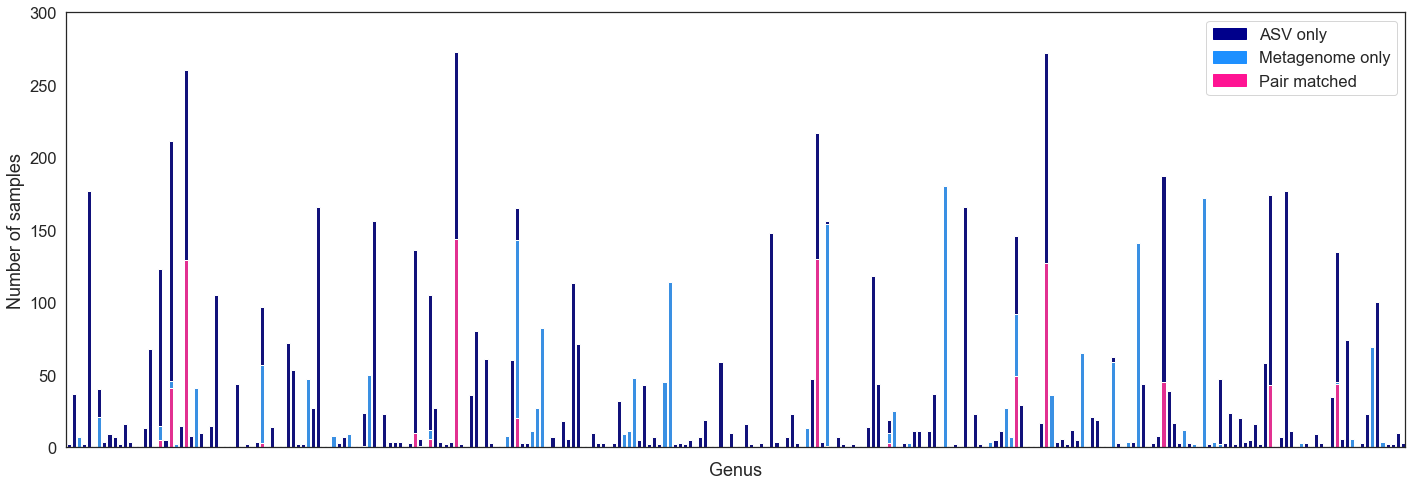

In [61]:
plt.figure(figsize=(24,8))
sns.set(font_scale = 1.5)
sns.set_style('white')
sns.set_palette(sns.color_palette('colorblind'))

# top bar -> sum all values(ASV only, pair matched, and metagenome only) to find y position of the bars
total = df_final.groupby('Genus')['Count'].sum().reset_index()

# bar chart 1 -> top bars (total counts)
bar1 = sns.barplot(x="Genus",  y="Count", data=total, color='darkblue', alpha=1)

# bottom bar 1 ->  take only metagenome-only values from the data
mgns = df_final[df_final['Observation group']=='Metagenome only']

# bar chart 2 -> bottom bars (group of 'Metagenome only')
bar2 = sns.barplot(x="Genus",  y="Count", data=mgns, color='dodgerblue', alpha=1) # estimator=sum, ci=None,  

# bottom bar 2 ->  take only pair matched samples
pairs = df_final[df_final['Observation group']=='Pair matched']

# bar chart 3 -> bottom bars (pair matched samples)
bar3 = sns.barplot(x="Genus",  y="Count", data=pairs, color='deeppink', alpha=1) # estimator=sum, ci=None,  

# add legend
top_bar = mpatches.Patch(color='darkblue', label='ASV only')
middle_bar = mpatches.Patch(color='dodgerblue', label='Metagenome only')
bottom_bar = mpatches.Patch(color='deeppink', label='Pair matched')

plt.legend(handles=[top_bar, middle_bar, bottom_bar])

plt.ylabel("Number of samples", size=18)
bar1.set_xticklabels([])
plt.xlabel("Genus", size=18)

plt.ylim(0, 300)
plt.savefig('eCruises2018_2019_genera_metagenomes_COI_bars_ALL_stacked.svg', format='svg', dpi=1200, bbox_inches='tight')

### Split the entire df into smaller ones

#### First look at all taxa with any pair matching

In [62]:
df_subset_highpairmatches = df_final[(df_final['Observation group'] == 'Pair matched') &
                     (df_final['Count'] > 0)]
genus_a = df_subset_highpairmatches['Genus']
df_final_a = df_final[df_final['Genus'].isin(genus_a)]

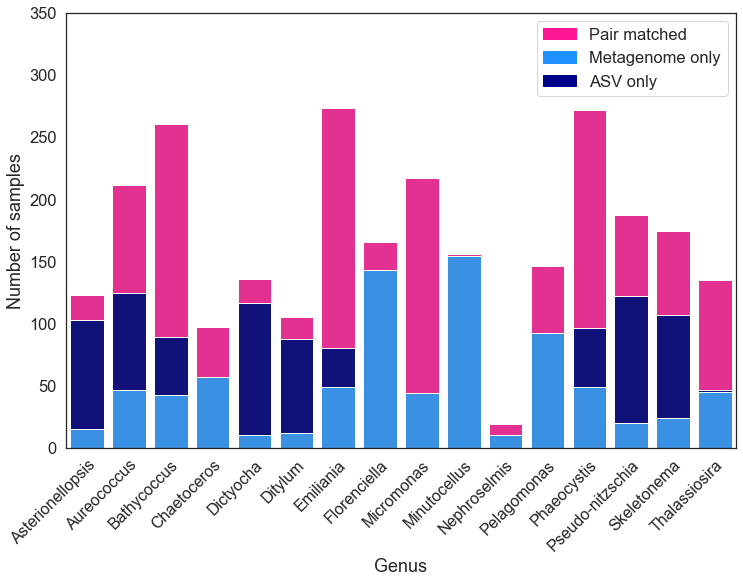

In [66]:
plt.figure(figsize=(12,8))
sns.set(font_scale = 1.5)
sns.set_style('white')

# top bar -> sum all values(ASV only, pair matched, and metagenome only) to find y position of the bars
total = df_final_a.groupby('Genus')['Count'].sum().reset_index()

# bar chart 1 -> top bars (total counts)
bar1 = sns.barplot(x="Genus",  y="Count", data=total, color='deeppink', alpha=1)

# bottom bar 1 ->  take only metagenome-only values from the data
mgns = df_final_a[df_final_a['Observation group']=='ASV only']

# bar chart 2 -> bottom bars (group of 'Metagenome only')
bar2 = sns.barplot(x="Genus",  y="Count", data=mgns, color='darkblue', alpha=1) # estimator=sum, ci=None,  

# bottom bar 2 ->  take only pair matched samples
pairs = df_final_a[df_final_a['Observation group']=='Metagenome only']

# bar chart 3 -> bottom bars (pair matched samples)
bar3 = sns.barplot(x="Genus",  y="Count", data=pairs, color='dodgerblue', alpha=1) # estimator=sum, ci=None,  

# add legend
top_bar = mpatches.Patch(color='darkblue', label='ASV only')
middle_bar = mpatches.Patch(color='dodgerblue', label='Metagenome only')
bottom_bar = mpatches.Patch(color='deeppink', label='Pair matched')

plt.legend(handles=[bottom_bar, middle_bar, top_bar])

plt.ylabel("Number of samples", size=18)
bar1.set_xticklabels(bar1.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor',
                    size=16)
plt.xlabel("Genus", size=18)
plt.ylim(0, 350)

plt.savefig('eCruises2018_2019_genera_metagenomes_COI_bars_pairmatches_stacked.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

#### Genera with high levels of ASV-only observations

In [75]:
df_subset_highasvonly = df_final[(df_final['Observation group'] == 'ASV only') &
                     (df_final['Count'] > 10)]
genus_b = df_subset_highasvonly['Genus']
df_final_b = df_final[df_final['Genus'].isin(genus_b)]

#### Stacked bar plot

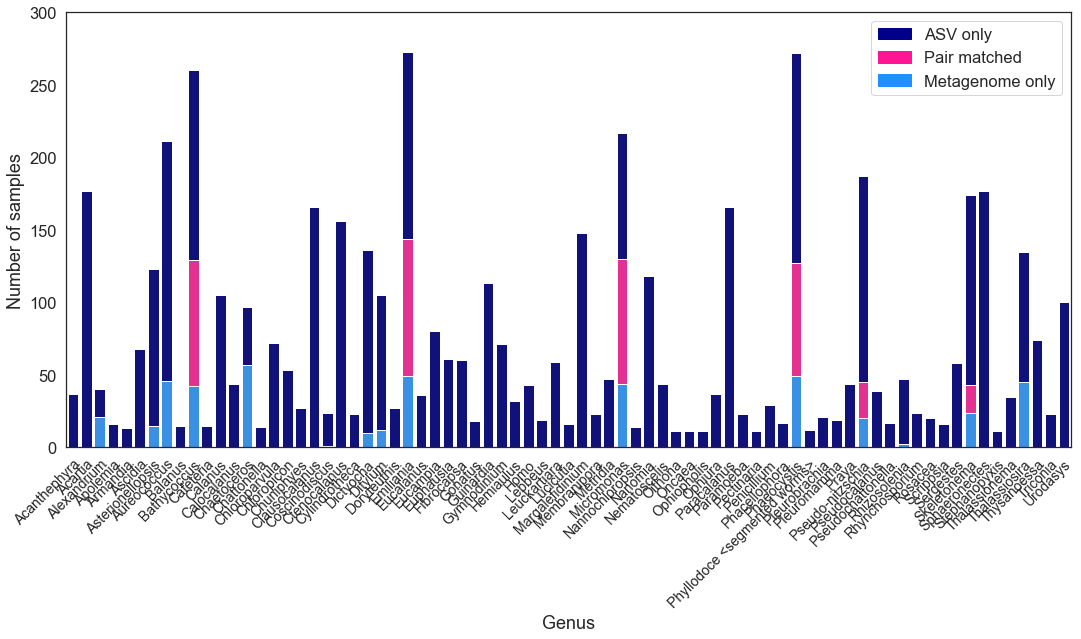

In [77]:
plt.figure(figsize=(18,8))
sns.set(font_scale = 1.5)
sns.set_style('white')
sns.set_palette(sns.color_palette('colorblind'))

# top bar -> sum all values(ASV only, pair matched, and metagenome only) to find y position of the bars
total = df_final_b.groupby('Genus')['Count'].sum().reset_index()

# bar chart 1 -> top bars (total counts)
bar1 = sns.barplot(x="Genus",  y="Count", data=total, color='darkblue', alpha=1)

# bottom bar 1 ->  take only metagenome-only values from the data
mgns = df_final_b[df_final_b['Observation group']=='Pair matched']

# bar chart 2 -> bottom bars (group of 'Metagenome only')
bar2 = sns.barplot(x="Genus",  y="Count", data=mgns, color='deeppink', alpha=1) # estimator=sum, ci=None,  

# bottom bar 2 ->  take only pair matched samples
pairs = df_final_b[df_final_b['Observation group']=='Metagenome only']

# bar chart 3 -> bottom bars (pair matched samples)
bar3 = sns.barplot(x="Genus",  y="Count", data=pairs, color='dodgerblue', alpha=1) # estimator=sum, ci=None,  

# add legend
top_bar = mpatches.Patch(color='darkblue', label='ASV only')
middle_bar = mpatches.Patch(color='deeppink', label='Pair matched')
bottom_bar = mpatches.Patch(color='dodgerblue', label='Metagenome only')

plt.legend(handles=[top_bar, middle_bar, bottom_bar])

plt.ylabel("Number of samples", size=18)
bar1.set_xticklabels(bar1.get_xticklabels(), rotation=45, size=14, ha='right', rotation_mode='anchor')
plt.ylim(0, 300)
plt.savefig('eCruises2018_2019_genera_metagenomes_COI_bars_10plusasvsonly_stacked.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

#### Genera with any metagenome-only observations

In [78]:
df_subset_highmgnonly = df_final[(df_final['Observation group'] == 'Metagenome only') &
                     (df_final['Count'] > 0)]
genus_c = df_subset_highmgnonly['Genus']
df_final_c = df_final[df_final['Genus'].isin(genus_c)]

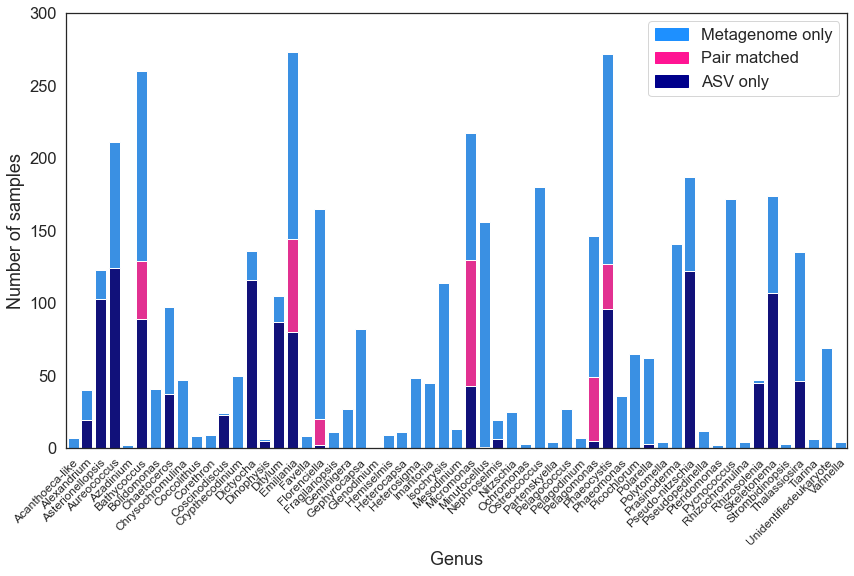

In [81]:
plt.figure(figsize=(14,8))
sns.set(font_scale = 1.5)
sns.set_style('white')

# top bar -> sum all values(ASV only, pair matched, and metagenome only) to find y position of the bars
total = df_final_c.groupby('Genus')['Count'].sum().reset_index()

# bar chart 1 -> top bars (total counts)
bar1 = sns.barplot(x="Genus",  y="Count", data=total, color='dodgerblue', alpha=1)

# bottom bar 1 ->  take only metagenome-only values from the data
mgns = df_final_c[df_final_c['Observation group']=='Pair matched']

# bar chart 2 -> bottom bars (group of 'Metagenome only')
bar2 = sns.barplot(x="Genus",  y="Count", data=mgns, color='deeppink', alpha=1) # estimator=sum, ci=None,  

# bottom bar 2 ->  take only pair matched samples
pairs = df_final_c[df_final_c['Observation group']=='ASV only']

# bar chart 3 -> bottom bars (pair matched samples)
bar3 = sns.barplot(x="Genus",  y="Count", data=pairs, color='darkblue', alpha=1) # estimator=sum, ci=None,  

# add legend
top_bar = mpatches.Patch(color='dodgerblue', label='Metagenome only')
middle_bar = mpatches.Patch(color='deeppink', label='Pair matched')
bottom_bar = mpatches.Patch(color='darkblue', label='ASV only')

plt.legend(handles=[top_bar, middle_bar, bottom_bar])

plt.ylabel("Number of samples", size=18)
bar1.set_xticklabels(bar1.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor',
                    size=12)
plt.ylim(0, 300)
plt.savefig('eCruises2018_2019_genera_metagenomes_COI_bars_mgnsonly_stacked.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

### Make histograms of number of genera in each observation group

#### Without y-axis break

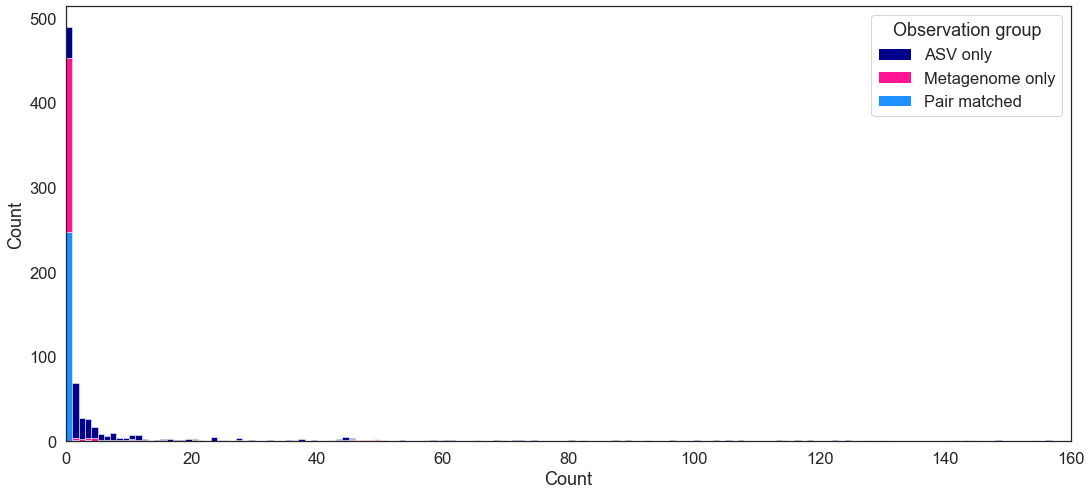

In [83]:
plt.figure(figsize=(18,8))
sns.set(font_scale = 1.5)
sns.set_style('white')
sns.set_palette(['darkblue','deeppink','dodgerblue'])

ax = sns.histplot(data=df_final, x='Count', hue='Observation group', 
                    alpha=1.0, binwidth=1, multiple='stack')

ax.set_xlim(0, 160)

plt.show()

#### With y-axis break

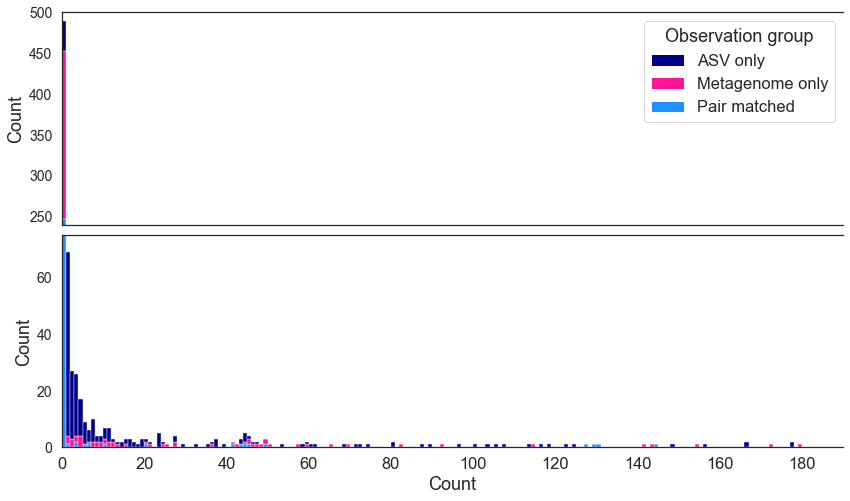

In [92]:
sns.set(font_scale = 1.5)
sns.set_style('white')
sns.set_palette(['darkblue','deeppink','dodgerblue'])

f, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(14,8))
ax = sns.histplot(data=df_final, x='Count', hue='Observation group', 
                    alpha=1.0, binwidth=1, ax=ax1, multiple='stack')
ax = sns.histplot(data=df_final, x='Count', hue='Observation group', 
                    alpha=1.0, binwidth=1, ax=ax2, multiple='stack')
sns.despine(right=True, top=False) # , left = True
ax1.tick_params(axis='y', which='major', labelsize=14)
ax2.tick_params(axis='y', which='major', labelsize=14)
ax1.tick_params(axis='x', which='both', labelsize=14)
ax2.legend([],[], frameon=False)

ax1.set_ylim(240, 500)
ax2.set_ylim(0, 75)
ax1.set_xlim(0, 190)
plt.xticks(np.arange(0, 190, 20))
plt.subplots_adjust(wspace=0, hspace=0.05)

In [93]:
f.savefig('eCruises2018_2019_genera_metagenomes_COI_histogram.svg', format='svg', dpi=1200, bbox_inches='tight')